###  In this notebook, we do the following:
* Extract and organize data for air quality, deaths, as well as confounding variables
* Run EDA to see of we have a relationship between air quality and deaths
* Predict deaths using all features and then subsets of features

Import modules and libraries required for project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from sklearn.model_selection import train_test_split
from sklearn import cluster, datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

/Users/jitsen/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import data pertaining to air quality measures

In [2]:
Air_Qual = pd.read_csv('Air_Qual.csv')

Death_2012_1 = pd.read_csv('Underlying Cause of Death, 2012.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2012_1['Year'] = 2012
Death_2013_1 = pd.read_csv('Underlying Cause of Death, 2013.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2013_1['Year'] = 2013
Death_2014_1 = pd.read_csv('Underlying Cause of Death, 2014.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2014_1['Year'] = 2014
Death_2015_1 = pd.read_csv('Underlying Cause of Death, 2015.txt',sep='\t', usecols = ["ICD Sub-Chapter","ICD Sub-Chapter Code","State","State Code","County","County Code","2013 Urbanization","2013 Urbanization Code","Five-Year Age Groups","Five-Year Age Groups Code","Deaths","Population","Crude Rate","% of Total Deaths"])
Death_2015_1['Year'] = 2015

Import data on Diabetes

In [3]:
Diabetes = pd.read_csv('Diabetes.csv',sep=',', usecols = ['State','County','Prevalence, 1999, Both Sexes',
'Prevalence, 2000, Both Sexes','Prevalence, 2001, Both Sexes','Prevalence, 2002, Both Sexes',
'Prevalence, 2003, Both Sexes','Prevalence, 2004, Both Sexes','Prevalence, 2005, Both Sexes', 
'Prevalence, 2006, Both Sexes','Prevalence, 2007, Both Sexes','Prevalence, 2008, Both Sexes',
'Prevalence, 2009, Both Sexes','Prevalence, 2010, Both Sexes','Prevalence, 2011, Both Sexes',
'Prevalence, 2012, Both Sexes'])  

pandas_dict = {}
Year_list = [(2000,'2000'),(2001,'2001'),(2002,'2002'),(2003,'2003'),(2004,'2004'),
             (2005,'2005'),(2006,'2006'),(2007,'2007'),(2008,'2008'),(2009,'2009'),
             (2010,'2010'),(2011,'2011'),(2012,'2012')]
for k,v in Year_list:
    pandas_dict[k] = Diabetes[['State','County','Prevalence, %r, Both Sexes' %k]]

Diabetes_list = []
Diabetes = pd.DataFrame()
for k,v in pandas_dict.items():
    v['Year'] = k
    v.columns.values[2] = 'Prevalence of Diabetes'
    Diabetes_list.append(v)
Diabetes_Concat = pd.concat(Diabetes_list)
Diabetes_Concat['County'] = Diabetes_Concat['County'].apply(lambda x: x.split()[0])

Import data on Poverty

In [4]:
import glob
import errno
import os
path = '/Users/jitsen/Documents/metis/metisgh/CDC/Poverty_Death_D3'
content = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    content.append(filename)
    
Poverty = pd.read_csv(content[0],usecols = ['Year','State / County Name','All Ages in Poverty Percent',
                                           'Median Household Income in Dollars'])
for i in content[1:]:
    Poverty = pd.concat([Poverty, pd.read_csv(i,usecols = ['Year','State / County Name','All Ages in Poverty Percent',
                                                          'Median Household Income in Dollars'])])

In [5]:
Poverty['County'] = Poverty['State / County Name'].apply(lambda x : x.split()[0])
Poverty['State'] = Poverty['State / County Name'].apply(lambda x : x.split()[-1][1:3])
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado',
        'CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam',
        'HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky',
        'LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota',
        'MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
        'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada',
        'NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
        'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia',
        'VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}

Poverty['State'] = Poverty['State'].map(states)

Poverty['Median_Income'] = Poverty['Median Household Income in Dollars'].apply(lambda x : re.sub('[^0-9]','',str(x)))
Poverty['Median_Income'] = pd.to_numeric(Poverty['Median_Income'], errors='coerce')

Merge tables on Diabetes and Poverty

In [6]:
Diabetes_Poverty= pd.merge(Diabetes_Concat, Poverty,left_on = ['County','Year','State'],
                  right_on = ['County','Year','State'])

Checking if intergerity if tables were preserved

In [7]:
Diabetes_Poverty['Year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012])

Select the correct metric for air pollution measurement (P2.5 density)

In [8]:
Air_Qual_2_5 = Air_Qual[Air_Qual['MeasureId']==296]

Merge data on Diabetes, Poverty and Air Quality

In [9]:
Diabetes_Poverty_Air_Qual_2_5 = pd.merge(Diabetes_Poverty,Air_Qual_2_5,
                left_on = ['County','Year','State'], 
                                right_on = ['CountyName','ReportYear','StateName'])

Make squared term for air pollution in case relationship to death is not linear

In [10]:
Diabetes_Poverty_Air_Qual_2_5['Value_sq'] = Diabetes_Poverty_Air_Qual_2_5['Value'].apply(
lambda x: x**2 )

Create tables in order to find moving averages of features (to be used later)

In [11]:
DPA_2008 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2001)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2008)]
DPA_2009 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2002)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2009)]
DPA_2010 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2003)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2010)]
DPA_2011 = Diabetes_Poverty_Air_Qual_2_5[(Diabetes_Poverty_Air_Qual_2_5['ReportYear'] >= 2004)&
                                        (Diabetes_Poverty_Air_Qual_2_5['ReportYear'] <= 2011)]


In [12]:
DPA_2008_mean = DPA_2008[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq']].groupby(['State','County']).mean()
DPA_2008_mean = DPA_2008_mean.reset_index()
DPA_2008_mean['Comp_Year'] = 2012

DPA_2009_mean = DPA_2009[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq']].groupby(['State','County']).mean()
DPA_2009_mean = DPA_2009_mean.reset_index()
DPA_2009_mean['Comp_Year'] = 2013

DPA_2010_mean = DPA_2010[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq']].groupby(['State','County']).mean()
DPA_2010_mean = DPA_2010_mean.reset_index()
DPA_2010_mean['Comp_Year'] = 2014

DPA_2011_mean = DPA_2011[['State', 'County', 'Prevalence of Diabetes', 'Year','State / County Name',
'Median_Income','All Ages in Poverty Percent','Value','Value_sq']].groupby(['State','County']).mean()
DPA_2011_mean = DPA_2011_mean.reset_index()
DPA_2011_mean['Comp_Year'] = 2015


Make master tables of information on deaths and other features

In [13]:
Death_concat = pd.concat([Death_2012_1,Death_2013_1,
               Death_2014_1,Death_2015_1])

Death_new = Death_concat[['State','County','2013 Urbanization','2013 Urbanization Code',
'Five-Year Age Groups','Deaths','Population','Year','ICD Sub-Chapter']]
Death_new['County'] = Death_new.County.str.split().str[0]
cols = ['State','County','2013 Urbanization','2013 Urbanization Code',
'Five-Year Age Groups','Deaths','Population','Year','ICD Sub-Chapter']
Death_new = Death_new.loc[:, cols].dropna()

DPA_concat = pd.concat([DPA_2008_mean,DPA_2009_mean,DPA_2010_mean,DPA_2011_mean])


/Users/jitsen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Merge above tables

In [14]:
Death_DPA_merge = pd.merge(DPA_concat, Death_new,left_on = ['State','County','Comp_Year'],
                          right_on = ['State','County','Year'])

Select only COPD (Chronic Obstructive Pulmonary Disease) for analysis

In [15]:
Death_DPA_merge = Death_DPA_merge[Death_DPA_merge['Population'] != 'Not Applicable']
Death_DPA_merge['Population'] = Death_DPA_merge['Population'].astype('int')
Death_DPA_merge['prop_death'] = Death_DPA_merge['Deaths']/Death_DPA_merge['Population']
Death_DPA_merge['Five-Year Age Groups'] = Death_DPA_merge['Five-Year Age Groups'].apply(
lambda x : (int(x[3:5])+int(x[0:2]))/2)
Death_DPA_merge
Death_DPA_merge_COPD = Death_DPA_merge[Death_DPA_merge['ICD Sub-Chapter'] == 'Chronic lower respiratory diseases']

In [16]:
Death_DPA_merge_COPD.head()

,State,County,Prevalence of Diabetes,Year_x,Median_Income,All Ages in Poverty Percent,Value,Value_sq,Comp_Year,2013 Urbanization,2013 Urbanization Code,Five-Year Age Groups,Deaths,Population,Year_y,ICD Sub-Chapter,prop_death
11,Alabama,Baldwin,8.02125,2004.5,44353.625,10.5625,11.530307,133.452176,2012,Small Metro,4.0,77.0,13.0,6071,2012,Chronic lower respiratory diseases,0.002141
12,Alabama,Baldwin,8.02125,2004.5,44353.625,10.5625,11.530307,133.452176,2012,Small Metro,4.0,82.0,17.0,4114,2012,Chronic lower respiratory diseases,0.004132
17,Alabama,Blount,9.48625,2004.5,40049.500,12.6125,15.069577,227.865066,2012,Large Fringe Metro,2.0,67.0,10.0,3163,2012,Chronic lower respiratory diseases,0.003162
27,Alabama,Calhoun,10.75500,2004.5,35238.500,16.8250,14.551696,212.497484,2012,Small Metro,4.0,62.0,10.0,7314,2012,Chronic lower respiratory diseases,0.001367
28,Alabama,Calhoun,10.75500,2004.5,35238.500,16.8250,14.551696,212.497484,2012,Small Metro,4.0,77.0,12.0,3358,2012,Chronic lower respiratory diseases,0.003574


Add geo-coordinates to master dataset as an added feature

In [17]:
Geo_coord = pd.read_csv('zip_codes_states.csv')
Geo_coord['state'] = Geo_coord['state'].map(states)
Geo_coord_mean = Geo_coord.groupby(['state','county',]).mean()
Geo_coord_mean = Geo_coord_mean.reset_index()
Death_m_concat_geo = pd.merge(Death_DPA_merge_COPD,Geo_coord_mean, left_on = ['State','County'],
                              right_on = ['state','county'])

In [18]:
def cause(age_group, metro):   
    #new_df5 = new_df5[new_df5['Value'] < 40]
    df = Death_m_concat_geo[Death_m_concat_geo['Five-Year Age Groups'] == age_group]
    #new_df2['Prop_death'] = new_df2['Prop_death'].apply(lambda x : np.log(x))
    df = df[df['2013 Urbanization'] == metro]
    new_list = [x for x in zip(df['prop_death'],df['Value_sq'])]
    new_list2 = sorted(new_list, key=lambda x: x[1])
    return new_list2


Run EDA having controlled for metro size and age group

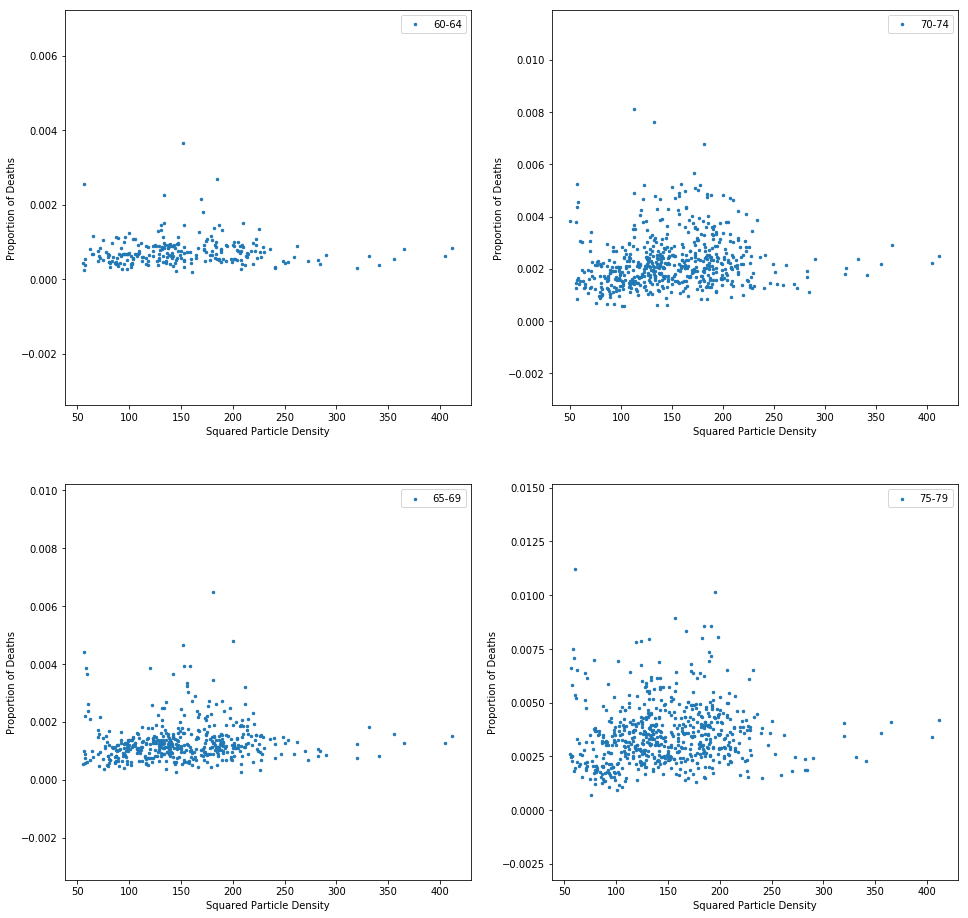

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (16,16));
axes[0,0].scatter([x[1] for x in cause(62, 'Medium Metro') ],[x[0] for x in cause(62, 'Medium Metro')], 
            label = '60-64',s=6);
axes[0,0].set_xlabel('Squared Particle Density')
axes[0,0].set_ylabel('Proportion of Deaths')
axes[1,0].scatter([x[1] for x in cause(67, 'Medium Metro') ],[x[0] for x in cause(67, 'Medium Metro')], 
            label = '65-69',s=6);
axes[1,0].set_xlabel('Squared Particle Density')
axes[1,0].set_ylabel('Proportion of Deaths')
axes[0,1].scatter([x[1] for x in cause(72, 'Medium Metro') ],[x[0] for x in cause(72, 'Medium Metro')], 
            label = '70-74', s=6);
axes[0,1].set_xlabel('Squared Particle Density')
axes[0,1].set_ylabel('Proportion of Deaths')
axes[1,1].scatter([x[1] for x in cause(77, 'Medium Metro') ],[x[0] for x in cause(77, 'Medium Metro')], 
            label = '75-79', s=6);
axes[1,1].set_xlabel('Squared Particle Density')
axes[1,1].set_ylabel('Proportion of Deaths')

axes[0,0].legend();
axes[0,1].legend();
axes[1,0].legend();
axes[1,1].legend();
plt.show();

There seems to be a relationship between particulate matter density and the proportion of deaths for given age groups. However, this could be because there are other, more dominant variables correlated with deaths. We must control for all confounders and run EDA (with hope to see relationship between proportion of deaths and particulate matter density).

In [20]:
X = Death_m_concat_geo[['Comp_Year','Prevalence of Diabetes','Median_Income',
       'All Ages in Poverty Percent','2013 Urbanization Code','Five-Year Age Groups',
      'Population','latitude', 'longitude']]

scaler = MinMaxScaler(feature_range=(0, 1))
X_ = scaler.fit_transform(X)
k_means = cluster.KMeans(n_clusters=80)
X_fit = k_means.fit(X_)
labels = X_fit.labels_
Death_m_concat_geo['clusters'] = labels

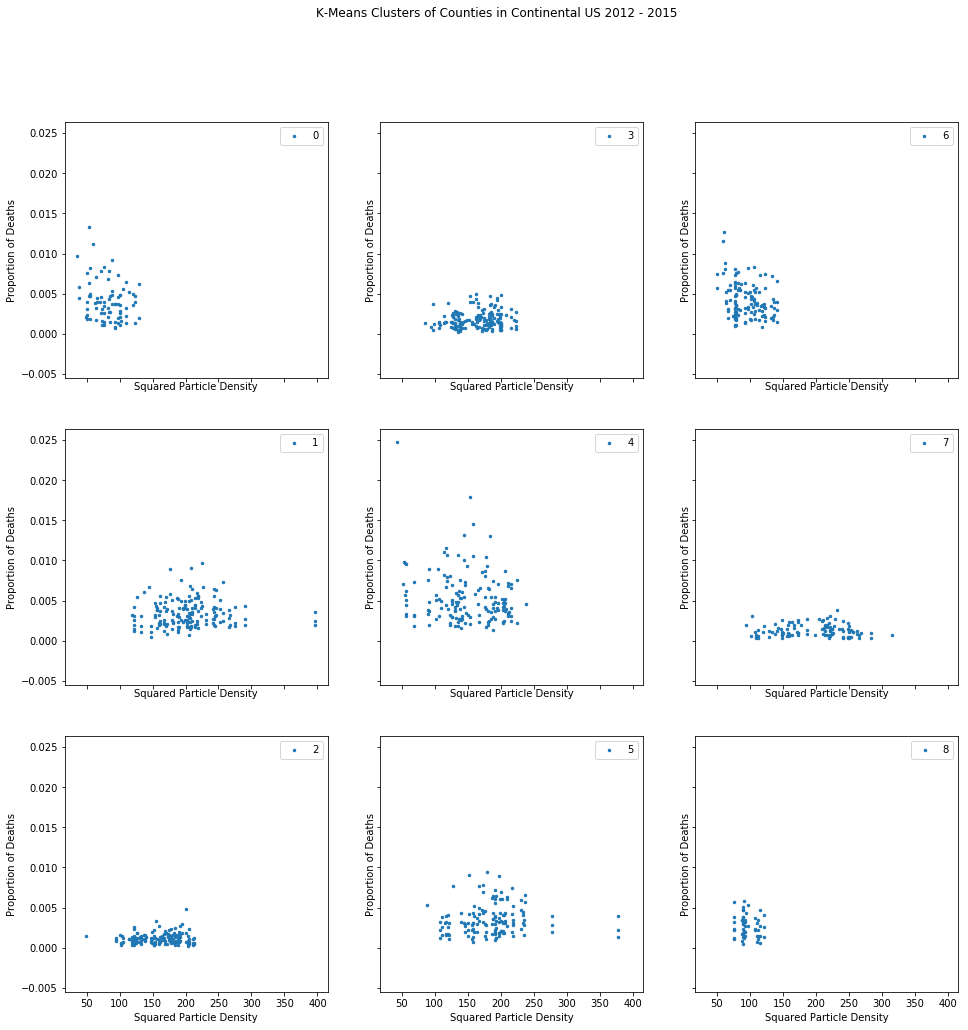

In [21]:
def cause_3(cluster):   
    df = Death_m_concat_geo[Death_m_concat_geo['clusters'] == cluster]
    #new_df5 = new_df5[new_df5['Value'] < 40]
    #new_df2['Prop_death'] = new_df2['Prop_death'].apply(lambda x : np.log(x))
    new_list = [x for x in zip(df['prop_death'],df['Value_sq'])]
    new_list2 = sorted(new_list, key=lambda x: x[1])
    return new_list2

fig, axes = plt.subplots(3, 3, figsize = (16,16), sharey=True, sharex = True);
axes[0,0].scatter([x[1] for x in cause_3(0) ],[x[0] for x in cause_3(0)], 
            label = '0',s=6);
axes[0,0].set_xlabel('Squared Particle Density')
axes[0,0].set_ylabel('Proportion of Deaths')
axes[1,0].scatter([x[1] for x in cause_3(1) ],[x[0] for x in cause_3(1)], 
            label = '1',s=6);
axes[1,0].set_xlabel('Squared Particle Density')
axes[1,0].set_ylabel('Proportion of Deaths')
axes[2,0].scatter([x[1] for x in cause_3(2) ],[x[0] for x in cause_3(2)], 
            label = '2', s=6);
axes[2,0].set_xlabel('Squared Particle Density')
axes[2,0].set_ylabel('Proportion of Deaths')
axes[0,1].scatter([x[1] for x in cause_3(3) ],[x[0] for x in cause_3(3)], 
            label = '3', s=6);
axes[0,1].set_xlabel('Squared Particle Density')
axes[0,1].set_ylabel('Proportion of Deaths')
axes[1,1].scatter([x[1] for x in cause_3(4) ],[x[0] for x in cause_3(4)], 
            label = '4', s=6);
axes[1,1].set_xlabel('Squared Particle Density')
axes[1,1].set_ylabel('Proportion of Deaths')
axes[2,1].scatter([x[1] for x in cause_3(5) ],[x[0] for x in cause_3(5)], 
            label = '5', s=6);
axes[2,1].set_xlabel('Squared Particle Density')
axes[2,1].set_ylabel('Proportion of Deaths')
axes[0,2].scatter([x[1] for x in cause_3(6) ],[x[0] for x in cause_3(6)], 
            label = '6', s=6);
axes[0,2].set_xlabel('Squared Particle Density')
axes[0,2].set_ylabel('Proportion of Deaths')
axes[1,2].scatter([x[1] for x in cause_3(7) ],[x[0] for x in cause_3(7)], 
            label = '7', s=6);
axes[1,2].set_xlabel('Squared Particle Density')
axes[1,2].set_ylabel('Proportion of Deaths')
axes[2,2].scatter([x[1] for x in cause_3(8) ],[x[0] for x in cause_3(8)], 
            label = '8', s=6);
axes[2,2].set_xlabel('Squared Particle Density')
axes[2,2].set_ylabel('Proportion of Deaths')
axes[0,0].legend();
axes[1,0].legend();
axes[2,0].legend();
axes[0,1].legend();
axes[1,1].legend();
axes[2,1].legend();
axes[0,2].legend();
axes[1,2].legend();
axes[2,2].legend();
plt.suptitle('K-Means Clusters of Counties in Continental US 2012 - 2015')

plt.show();

We still see some random results. Let's then control for confounders manually (and very tightly) to see if we can extract some correlation between particuate matter density and proportion of deaths.

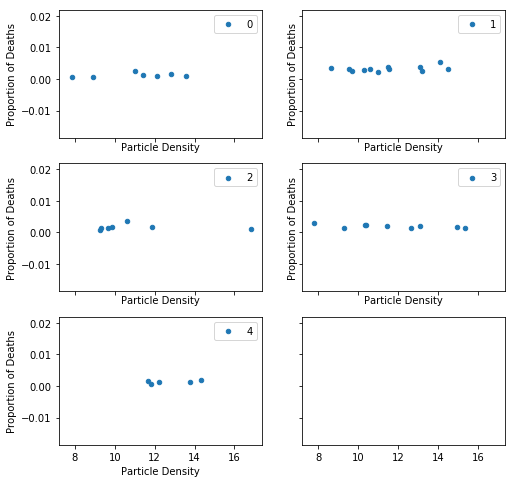

In [26]:
A = 40000
B = 50000
C = 10
D = 12
E = 8
F = 10
G = 3.0
H = 77 
I = 77
J = 2015

def cause_3(A,B,C,D,E,F,G,H,I,J):
    Death_Select = Death_m_concat_geo[(Death_m_concat_geo['Median_Income'].between(A, B, inclusive=True) & 
    Death_m_concat_geo['All Ages in Poverty Percent'].between(C, D, inclusive=True) &
    Death_m_concat_geo['Prevalence of Diabetes'].between(E, F, inclusive=False) &
          (Death_m_concat_geo['2013 Urbanization Code'] == G) &
    Death_m_concat_geo['Five-Year Age Groups'].between(H, I, inclusive=True)) &
    (Death_m_concat_geo['Comp_Year'] == J)]
    #new_df5 = new_df5[new_df5['Value'] < 40]
    #new_df2['Prop_death'] = new_df2['Prop_death'].apply(lambda x : np.log(x))
    new_list = [x for x in zip(Death_Select['prop_death'],Death_Select['Value'],
                               Death_Select['County']+" "+Death_Select['State'])]
    new_list2 = sorted(new_list, key=lambda x: x[1])
    return new_list2

fig, ax = plt.subplots(3,2,figsize = (8,8), sharey = True, sharex = True);
ax[0,0].scatter([x[1] for x in cause_3(45000,50000,10,12,8,10,3.0,67,67,2015)],
            [x[0] for x in cause_3(45000,50000,10,12,8,10,3.0,67,67,2015)], 
            label = '0',s=20);
ax[0,0].set_xlabel('Particle Density')
ax[0,0].set_ylabel('Proportion of Deaths')

ax[0,1].scatter([x[1] for x in cause_3(40000,45000,13,15,8,10,3.0,77,77,2015)],
           [x[0] for x in cause_3(40000,45000,13,15,8,10,3.0,77,77,2015)], 
            label = '1',s=20);
ax[0,1].set_xlabel('Particle Density')
ax[0,1].set_ylabel('Proportion of Deaths')

ax[1,0].scatter([x[1] for x in cause_3(50000,55000,8,10,6,8,3.0,72,72,2012)],
            [x[0] for x in cause_3(50000,55000,8,10,6,8,3.0,72,72,2012)], 
            label = '2',s=20);
ax[1,0].set_xlabel('Particle Density')
ax[1,0].set_ylabel('Proportion of Deaths')

ax[1,1].scatter([x[1] for x in cause_3(50000,55000,8,10,7,9,3.0,72,72,2014)],
           [x[0] for x in cause_3(50000,55000,8,10,7,9,3.0,72,72,2014)], 
           label = '3',s=20);
ax[1,1].set_xlabel('Particle Density')
ax[1,1].set_ylabel('Proportion of Deaths')

ax[2,0].scatter([x[1] for x in cause_3(40000,45000,15,17,9,11,3.0,67,67,2013)],
           [x[0] for x in cause_3(40000,45000,15,17,9,11,3.0,67,67,2013)], 
           label = '4',s=20);
ax[2,0].set_xlabel('Particle Density')
ax[2,0].set_ylabel('Proportion of Deaths')


ax[0,0].legend();
ax[0,1].legend();
ax[1,0].legend();
ax[1,1].legend();
ax[2,0].legend();
plt.show();


The above results do not look promising. In any case, let's move towards predicting deaths. Let's first look at the distribution of death counts.

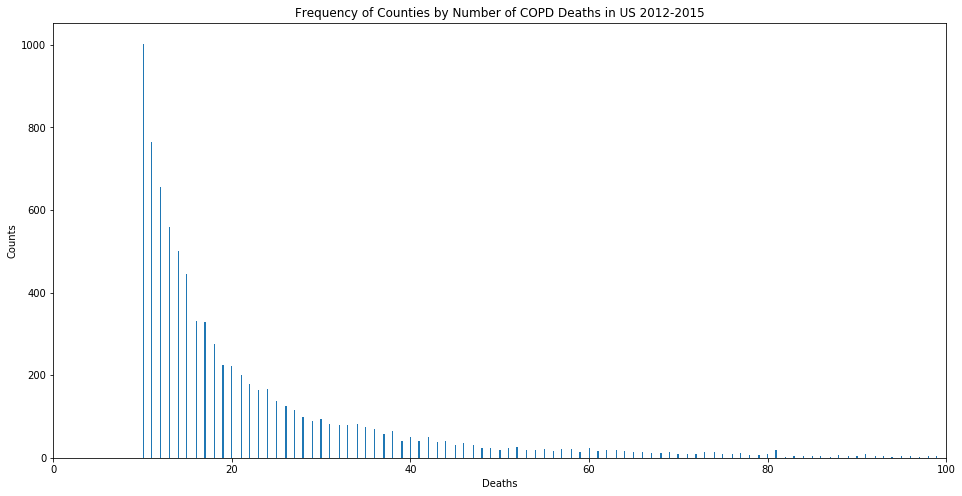

In [44]:
plt.figure(figsize = (16,8));
plt.hist(Death_m_concat_geo['Deaths'],bins=2000);
plt.xlim(0,100);
plt.xlabel('Deaths')
plt.ylabel('Counts')
plt.title('Frequency of Counties by Number of COPD Deaths in US 2012-2015')
plt.show();

The dataset seems to lend itself to a poisson model, since the distribution looks that way. Let's run a poisson model using all features to predict death counts per county, per age group. Let's also turn our proportion of death to deaths per 100000.

In [30]:
X_sm = Death_m_concat_geo[['Comp_Year','Prevalence of Diabetes',
       'All Ages in Poverty Percent','Value','2013 Urbanization Code',
       'latitude', 'longitude','Population','Five-Year Age Groups']]

X_sm_spec = X_sm[(X_sm['Five-Year Age Groups']>=1)&
                (X_sm['Population']>=1)&(X_sm['Population']<=100000) &
                (X_sm['Value']>=1)]

y_sm_spec  = Death_m_concat_geo[(Death_m_concat_geo['Five-Year Age Groups']>=1)&
                               (Death_m_concat_geo['Population']>=1)&(Death_m_concat_geo['Population']<=100000)
                               & (X_sm['Value']>=1)]

y_sm_spec = y_sm_spec['prop_death']*100000

scaler = MinMaxScaler(feature_range=(0, 1))
X_sm_t = scaler.fit_transform(X_sm_spec)

#X_sm_t = pd.DataFrame(X_sm_t, columns = ["Year","Five-Year Age Groups",'Median_Income',
#                   'All Ages in Poverty Percent','Prevalence of Diabetes',
#'2013 Urbanization Code','Value'])

X_sm_t_new = sm.add_constant(X_sm_t)

X_train, X_test, y_train, y_test = train_test_split(X_sm_t_new, y_sm_spec, test_size = .5)

sm_pois = sm.GLM(y_train,X_train, family =  Poisson()).fit_regularized()
sm_pois.params

const    4.392697
x1      -0.053932
x2       0.555357
x3       0.059758
x4      -0.007397
x5       0.383805
x6      -0.185097
x7      -0.219628
x8      -2.872933
x9       1.865881
dtype: float64

Find R^2 manually, since the the GLM doesn't automatocally do this.

In [31]:
y_pred = sm_pois.predict(X_test)

def r2(a,b):
    SSE = 0
    SST = 0
    for i, j in zip(a,b):
        SSE += (j - i)**2
        SST += (i - a.mean())**2 
    return 1 - SSE/SST

r2(y_test,y_pred)

0.70608570257253356

Let's try the same with a Negative Binomial Model

In [32]:
sm_nb = sm.GLM(y_train,X_train, family = sm.families.NegativeBinomial()).fit()
sm_nb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             prop_death   No. Observations:                 4079
Model:                            GLM   Df Residuals:                     4069
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                  0.129990261232
Method:                          IRLS   Log-Likelihood:                -26388.
Date:                Sun, 17 Jun 2018   Deviance:                       498.09
Time:                        09:36:46   Pearson chi2:                     529.
No. Iterations:                     9                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1455      0.049     63.859      0.000       3.049       3.242
x1            -0.0772      0.017     -4.655      0.000      -0.110      -0.045
x2             0.9723      0.085     11.485      0.000       0.806       1.138
x3             0.1954      0.073      2.664      0.008       0.052       0.339
x4             0.0081      0.052      0.155      0.876      -0.094       0.110
x5             0.4990      0.031     16.133      0.000       0.438       0.560
x6            -0.0786      0.033     -2.403      0.016      -0.143      -0.014
x7            -0.2408      0.026     -9.239      0.000      -0.292      -0.190
x8            -1.4212      0.049    -28.808      0.000      -1.518      -1.325
x9             2.8255      0.034     83.569      0.000       2.759       2.892
==============================================================================
"""

In [33]:
y_pred_nb = sm_nb.predict(X_test)

def r2(a,b):
    SSE = 0
    SST = 0
    for i, j in zip(a,b):
        SSE += (j - i)**2
        SST += (i - a.mean())**2 
    return 1 - SSE/SST

r2(y_test,y_pred_nb)

0.67325156154169552

The R^2 seems marginally poorer. Run linear model to do the same. Here we run three models: one with all the features, one without particulate matter density, and one with particulate density alone.

In [34]:
Death_m_concat_geo_2 = Death_m_concat_geo[Death_m_concat_geo['Five-Year Age Groups']>=1]

X_lr_1 = Death_m_concat_geo_2[['Comp_Year','Prevalence of Diabetes',
       'All Ages in Poverty Percent', 'Value','2013 Urbanization Code',
       'latitude', 'longitude','Population','Five-Year Age Groups']]

X_lr_2 = Death_m_concat_geo_2[['Comp_Year','Prevalence of Diabetes','Median_Income',
       'All Ages in Poverty Percent','2013 Urbanization Code',
       'latitude', 'longitude','Population','Five-Year Age Groups']]

X_lr_3 = Death_m_concat_geo_2[['Value', 'Value_sq']]

y_lr = Death_m_concat_geo_2['Deaths']

scaler = MinMaxScaler(feature_range=(0, 1))

X_lr_t1 = scaler.fit_transform(X_lr_1)
X_lr_t2 = scaler.fit_transform(X_lr_2)
X_lr_t3 = scaler.fit_transform(X_lr_3)

lr1 = LinearRegression()
lr2 = LinearRegression()
lr3 = LinearRegression()

lr1.fit(X_lr_t1, y_lr)
lr2.fit(X_lr_t2, y_lr)
lr3.fit(X_lr_t3, y_lr)

print(lr1.score(X_lr_t1, y_lr),lr2.score(X_lr_t2, y_lr),lr3.score(X_lr_t3, y_lr))

0.372869699453 0.377889856762 0.0559409077674


The scores for the linear model seem very poor, and should not be considered. Run Random Forest model to predict death counts.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_lr_1, Death_m_concat_geo_2['prop_death']*1000, test_size=0.3)
for i in range(10)[1:]:    
    rand_forest = RandomForestRegressor(n_estimators=5+i, min_samples_split=2*(i))
    rand_forest.fit(X_train, y_train)
    y_test_pred_rand_forest = rand_forest.predict(X_test)
    print('n_estimators:',(5+i), rand_forest.score(X_test,y_test),
          'min_samples_split:',5*(i), rand_forest.score(X_train, y_train),
         rand_forest.feature_importances_)

n_estimators: 6 0.859128502047 min_samples_split: 5 0.971437600338 [ 0.00549757  0.02036588  0.01871249  0.02100118  0.0041012   0.01759876
  0.0223694   0.72622421  0.1641293 ]
n_estimators: 7 0.863655689159 min_samples_split: 10 0.970455945508 [ 0.00465074  0.02027522  0.01871775  0.01969946  0.00337302  0.01776549
  0.02281701  0.72165321  0.1710481 ]
n_estimators: 8 0.865334450825 min_samples_split: 15 0.966394313539 [ 0.00378604  0.01772019  0.01921203  0.01954811  0.00333975  0.01671431
  0.02191551  0.7119432   0.18582087]
n_estimators: 9 0.86898882002 min_samples_split: 20 0.96061116853 [ 0.00288992  0.01754558  0.01590657  0.01882644  0.00344783  0.01837355
  0.02222733  0.71545174  0.18533104]
n_estimators: 10 0.872035284906 min_samples_split: 25 0.956562278847 [ 0.00324277  0.01524231  0.01407949  0.0163543   0.00294596  0.01567843
  0.02204703  0.73044971  0.17996   ]
n_estimators: 11 0.867206344338 min_samples_split: 30 0.951453028984 [ 0.0022465   0.01453796  0.01286977  

The R^2 of a Random Frest Regressor seems to be the best. However, this is with taking all our features into consideration. In a seprate notebook, we discuss trying to isolate the effect.